Dataset can be found here: https://www.kaggle.com/datasets/nikhileswarkomati/suicide-watch

In [38]:
import pandas as pd
# load data
data = pd.read_csv(r"C:\Users\ayanc\PycharmProjects\dspfinal\datasets\redditnlp\Suicide_Detection.csv")
data.drop(["Unnamed: 0", ], axis=1, inplace=True)
data

,text,class
0,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,Am I weird I don't get affected by compliments...,non-suicide
2,Finally 2020 is almost over... So I can never ...,non-suicide
3,i need helpjust help me im crying so hard,suicide
4,"I’m so lostHello, my name is Adam (16) and I’v...",suicide
...,...,...
232069,If you don't like rock then your not going to ...,non-suicide
232070,You how you can tell i have so many friends an...,non-suicide
232071,pee probably tastes like salty tea😏💦‼️ can som...,non-suicide
232072,The usual stuff you find hereI'm not posting t...,suicide


In [39]:
# train test split for training/eval
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data["text"], data["class"], test_size=0.1)
X_train

147246    Today I finally smashed my crush! Her brain wa...
4196      Girls notes Some peoples notes look exactly li...
116138    Posts here are basically ignored unless you're...
26233     I don't know what I'm doing anymore. I'm hurt ...
165308    I hate forcing a smile!\nI can’t stand it. For...
                                ...                        
22594     Idk what to title this I don't care all that m...
200184    Lemme rate you playlists again Yeah idk going ...
4638      My life fell apart, what now?I love my girlfri...
212474    someone all to me please i’m lonely and bored ...
166293    Nobody cares about meI have nobody to seriousl...
Name: text, Length: 208866, dtype: object

In [40]:
# Word2Vec equivalent in sklearn
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer()
X_train_transformed = vect.fit_transform(X_train)
X_train_transformed

<208866x158278 sparse matrix of type '<class 'numpy.int64'>'
	with 14806022 stored elements in Compressed Sparse Row format>

In [72]:
# regularized linear regression
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
lgr = LogisticRegressionCV(max_iter=10000000, Cs=[.001, .01, .1, .5])
lgr.fit(X_train_transformed, y_train)

LogisticRegressionCV(Cs=[0.001, 0.01, 0.1, 0.5], max_iter=10000000)

In [74]:
lgr.get_params()

{'Cs': [0.001, 0.01, 0.1, 0.5],
 'class_weight': None,
 'cv': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1.0,
 'l1_ratios': None,
 'max_iter': 10000000,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'refit': True,
 'scoring': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0}

In [75]:
roc_auc_score(y_test, lgr.predict_proba(vect.transform(X_test))[:,1])

0.9811545787637409

In [76]:
vect.vocabulary
list(vect.vocabulary_.keys())[list(vect.vocabulary_.values()).index(11367)]

'85410'

In [58]:
lgr.coef_[0]

array([-0.57631827,  0.15711453, -0.06336563, ..., -0.01364632,
       -0.01523187, -0.01523187])

In [77]:
# standard linear regression
X_test_transformed = vect.transform(X_test)
pred = lgr.predict_proba(X_test_transformed)

In [82]:
y_pred = pred[:,1]

In [32]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, pred[:,1])

0.9787005595936141

In [79]:
# re-encode to 1/0 for classification
y_test = [1 if y == "suicide" else 0 for y in y_test]

Text(0.5, 1.0, 'Text Classifier Precision-Recall Curve')

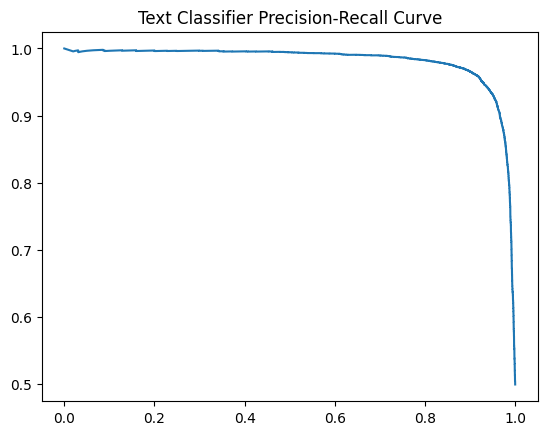

In [86]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
precision, recall, thresh = precision_recall_curve(y_test, y_pred)
plt.plot(recall, precision)
plt.title("Text Classifier Precision-Recall Curve")

Text(0.5, 1.0, 'Text Classifier ROC Curve')

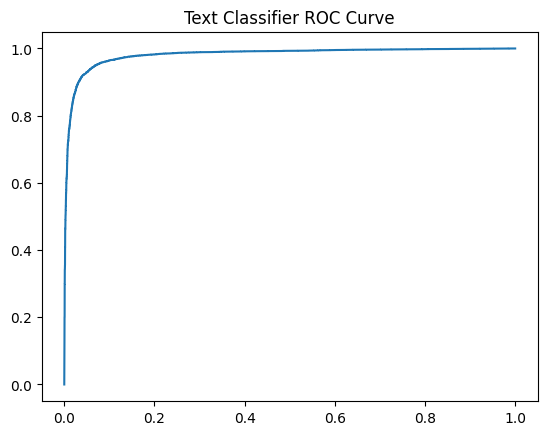

In [85]:
from sklearn.metrics import roc_curve

fpr, tpr, threshold = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr)
plt.title("Text Classifier ROC Curve")

In [37]:
# XGBoost ended up taking a long time for train/test, so we didn't end up using it more than an initial test
from xgboost import XGBClassifier 
from sklearn.model_selection import train_test_split, RandomizedSearchCV

# X['AGE'] = X['AGE'].astype('category')


params = dict(
    booster=["dart"],
    eta=[0.1, 0.2, 0.3, 0.4, 0.5],
    max_depth=[5, 6, 7, 8],
    subsample=[0.8, 0.9, 1],
    objective=["binary:logistic"],
    colsample_bytree=[0.5, 0.6, 0.7] 
)

y = [1 if x == "suicide" else 0 for x in data["class"]]

X_train, X_test, y_train, y_test = train_test_split(data["text"], y, test_size=.1)

X_train_transformed = vect.fit_transform(X_train)
X_test_transformed = vect.transform(X_test)
xgbc = XGBClassifier()
search = RandomizedSearchCV(xgbc, params, n_iter=10, n_jobs=-1, cv=3)
search.fit(X_train_transformed, y_train)
search.best_params_

KeyboardInterrupt: 

In [ ]:
# Tried tuning support vector machine, also didn't end up using in the end
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# https://www.geeksforgeeks.org/svm-hyperparameter-tuning-using-gridsearchcv-ml/
# used for hyperparameter ranges, really only effects regularization and learning rate
param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf']}  



svmc = SVC()
# svmc.fit(X_train, y_train)

search = GridSearchCV(svmc, param_grid)
search.fit(X, y)
params = search.best_params_

svmc = SVC(**params)
svmc.fit(X_train, y_train)